# Recomender system

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Part 1)

Aux functions

In [22]:
def rmse_mat_mat(mat_true, mat_pred):
    mat_true_na = mat_true.replace(0, np.nan)
    sum_err = (mat_true_na - mat_pred).apply(lambda x: x ** 2).sum().sum()
    count_err = mat_true_na.notna().sum().sum()
    return (sum_err / count_err) ** 0.5

<IPython.core.display.Javascript object>

Data ingestion

In [3]:
MV_users = pd.read_csv("../Data/users.csv")
MV_movies = pd.read_csv("../Data/movies.csv")
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

<IPython.core.display.Javascript object>

Data preparation

In [4]:
train_pivoted = train.pivot(index="uID", columns="mID", values="rating").fillna(0)
train_csr = csr_matrix(train_pivoted.values)

<IPython.core.display.Javascript object>

In [24]:
test_pivoted = test.pivot(index="uID", columns="mID", values="rating").fillna(0)

<IPython.core.display.Javascript object>

First model

In [84]:
n_comp = 5

<IPython.core.display.Javascript object>

In [6]:
svd = TruncatedSVD(n_components=n_comp)

<IPython.core.display.Javascript object>

In [7]:
svd.fit(train_csr,)

TruncatedSVD(n_components=5)

<IPython.core.display.Javascript object>

In [8]:
trained_user_preferences = svd.transform(train_pivoted)

<IPython.core.display.Javascript object>

In [9]:
trained_movie_features = svd.components_

<IPython.core.display.Javascript object>

In [10]:
trained_ratings = pd.DataFrame(
    data=np.dot(trained_user_preferences, trained_movie_features),
    index=train_pivoted.index,
    columns=train_pivoted.columns,
)

<IPython.core.display.Javascript object>

Metrics first model

In [23]:
rmse_mat_mat(train_pivoted, trained_ratings)

2.941013241453

<IPython.core.display.Javascript object>

In [25]:
rmse_mat_mat(test_pivoted, trained_ratings)

2.9677125998039307

<IPython.core.display.Javascript object>

Second model substracting mean rating of the training set.

In [26]:
mean_train = train["rating"].mean()

<IPython.core.display.Javascript object>

In [49]:
train["rating_mean"] = train["rating"] - mean_train

<IPython.core.display.Javascript object>

In [50]:
test["rating_mean"] = test["rating"] - mean_train

<IPython.core.display.Javascript object>

In [54]:
train_pivoted_2 = (
    train.drop(["rating"], axis=1)
    .pivot(index="uID", columns="mID", values="rating_mean")
    .fillna(0)
)
train_csr_2 = csr_matrix(train_pivoted_2.values)

<IPython.core.display.Javascript object>

In [63]:
test_pivoted_2 = (
    test.drop(["rating"], axis=1)
    .pivot(index="uID", columns="mID", values="rating_mean")
    .fillna(0)
)

<IPython.core.display.Javascript object>

In [85]:
svd = TruncatedSVD(n_components=n_comp)

<IPython.core.display.Javascript object>

In [86]:
svd.fit(train_csr_2,)

TruncatedSVD(n_components=5)

<IPython.core.display.Javascript object>

In [87]:
trained_user_preferences_2 = svd.transform(train_pivoted_2.values)

<IPython.core.display.Javascript object>

In [88]:
trained_movie_features_2 = svd.components_

<IPython.core.display.Javascript object>

In [89]:
trained_ratings_2 = pd.DataFrame(
    data=np.dot(trained_user_preferences_2, trained_movie_features_2),
    index=train_pivoted_2.index,
    columns=train_pivoted_2.columns,
)

<IPython.core.display.Javascript object>

Second model metrics

In [90]:
rmse_mat_mat(train_pivoted_2, trained_ratings_2)

1.0309791197260456

<IPython.core.display.Javascript object>

In [91]:
rmse_mat_mat(test_pivoted_2, trained_ratings_2)

1.0385018859507167

<IPython.core.display.Javascript object>

The transformation done improved results a lot because the SVD algorithm treats NaNs as zeros, so centering the data is important.<br>
Now let's do cross validation to see the effect of the number of components in the resulting metrics.

In [92]:
res_table = pd.DataFrame(columns=["rmse_train", "rmse_test"])
for n_comp in [2, 3, 5, 7, 10, 13, 16, 20, 25, 30, 40, 50, 70, 100]:
    svd = TruncatedSVD(n_components=n_comp)
    svd.fit(train_csr_2,)
    trained_user_preferences_2 = svd.transform(train_pivoted_2.values)
    trained_movie_features_2 = svd.components_
    trained_ratings_2 = pd.DataFrame(
        data=np.dot(trained_user_preferences_2, trained_movie_features_2),
        index=train_pivoted_2.index,
        columns=train_pivoted_2.columns,
    )
    res_table.loc[n_comp] = [
        rmse_mat_mat(train_pivoted_2, trained_ratings_2),
        rmse_mat_mat(test_pivoted_2, trained_ratings_2),
    ]

<IPython.core.display.Javascript object>

In [93]:
def line_plots(df, cols_to_plot, title="", x_label="Sample"):
    fig, ax = plt.subplots()
    ax.plot(df[cols_to_plot])
    ax.legend(cols_to_plot)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    return fig

<IPython.core.display.Javascript object>

In [96]:
res_table

,rmse_train,rmse_test
2,1.052644,1.054849
3,1.042844,1.046740
5,1.030954,1.038457
7,1.020794,1.032051
10,1.007975,1.024491
13,0.997764,1.020064
16,0.989997,1.019062
20,0.980080,1.017852
25,0.968765,1.017513
30,0.958494,1.017866


<IPython.core.display.Javascript object>

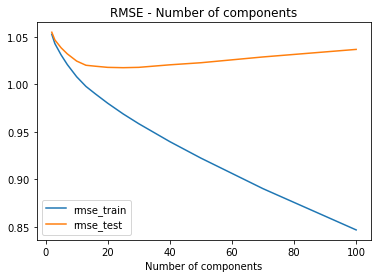

<IPython.core.display.Javascript object>

In [95]:
plot_rmse = line_plots(
    res_table,
    ["rmse_train", "rmse_test"],
    "RMSE - Number of components",
    "Number of components",
)

Increasing the amount of components increases the flexibility of the model, so the training set RMSE goes down. The testing set RMSE also goes down until 25 components and then start to rise due to overfitting.

Part 2)

The rmse on the test set is a very little improvement from the baseline of predicting the users average rating. This situation is the consequence of the sparcity of the training matrix and of the way Sklearn cast NaNs to 0. I believe that this model can be considerably improved by using a implementation of matrix factorization that exclude NaN values from the estimation of the coefficients. Implementing a gradient descent algorithm that excludes NaNs is not very complex because of how matrix multiplication is just the combination of many dot products which have a easly diferentiable form.